In [1]:
"""
File: survey2024.ipxnb
Author: Rich Sharples
Date: October-2024
Description: 
"""
  
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import textwrap

import plotly.express as px
import plotly.graph_objs as go

from collections import Counter


import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import csv

import math

# ignore category data less than this threshold
THRESHOLD = 4 

#
# Function : double_bar_chart
#
def double_bar_chart(qnum, qtext, ds1_name, data_series_1, ds2_name, data_series_2):

    ct = f"{qnum} : {qtext} (n={data_series_1.sum()+data_series_2.sum()})"
    
    # Create the figure with stacked bars
    fig = go.Figure(data=[
        go.Bar(name=ds1_name, x=data_series_1.index, y=data_series_1.values),
        go.Bar(name=ds2_name, x=data_series_2.index, y=data_series_2.values)
    ])

    # Update the layout to stack the bars
    fig.update_layout(
        barmode='stack',
        title=ct,
        plot_bgcolor="#FFFFFF",
        showlegend=True,
        xaxis={'categoryorder':'total descending'})

    fig.update_layout(width=900, height=500, bargap=0.2)
    
    # Show the plot
    fig.show()

    #Anything interesting in Other ?

    qother=qnum+"Other"

    others=[]
    if qother in raw_df.columns:
        for v in raw_df[qother]:
           others.append (v)

        # Create a Counter object to count the frequency of each string
        frequency_counts = Counter(others)

        # Convert the Counter to a list of tuples (unique string, count)
        unique_entries_with_counts = list(frequency_counts.items())

        # Sort by frequency (descending)
        sorted_by_frequency = sorted(unique_entries_with_counts, key=lambda x: x[1], reverse=True)

        listofothers=[]
    
        for x in sorted_by_frequency:
            if (not (str(x[0]) == "nan"))   & (x[1] > THRESHOLD):
                listofothers.append( (f"{x[0]}({x[1]})"))

        tmpstr = " ".join(listofothers)
  
        print(f"Other answers with frequency greater than {THRESHOLD} : {tmpstr}")
  


In [11]:
DATA_FILENAME = "raw-data-100724.xlsx"
QUESTION_FILENAME = "questions.csv"

#read questions from separate file
questions = { }
with open(QUESTION_FILENAME) as f:
    reader = csv.reader(f, skipinitialspace=True)
    questions = dict(reader)

raw_df = pd.read_excel(DATA_FILENAME)
 
raw_df.info()


#drop columns we don't care about
raw_df.drop (columns=['#', "Response Type", "Start Date (UTC)", "Stage Date (UTC)", "Submit Date (UTC)", "Network ID", "Tags"], inplace=True)

#rename remaining columns to make things easier to acces using "Qn" as the key


# Qs 15, 18, 19, 20 .Other contain commas which are also field delimiters so need to replace

raw_df.columns = raw_df.columns.str.replace(', please detail them here.', ' - please detail them here.')


col_names = {}
for q in questions.keys():
    col_names[questions[q]] = q

raw_df.rename( columns=col_names, inplace=True)

#
# data cleaning
#


# "$" signs in Q4 break plotly so replace with "USD"
tempdf = raw_df["Q4"] \
    .str.replace('US$', 'USD ', regex=False) \
    .str.replace('million', 'MM', regex=False) \
    .str.replace('billion', 'BB', regex=False) \
    .str.replace('$', 'USD ', regex=False)

raw_df["Q4"] = tempdf


# shorten country names in Q10

tempdf = raw_df["Q10"] \
    .str.replace('United Kingdom', 'UK', regex=False) \
    .str.replace('New Zealand', 'NZ', regex=False) \
    .str.replace('Czech Republic', 'CZ', regex=False) \
    .str.replace('United States', 'USA', regex=False)

raw_df["Q10"] = tempdf

# shorten Q11 answers
tempdf = raw_df["Q11"] \
    .str.replace('Developing and packaging custom developed software', 'custom s/w', regex=False) \
    .str.replace('Installing containerized open source software', 'OSS', regex=False) \
    .str.replace('Installing containerized commercial software', 'commercial s/w', regex=False) \

raw_df["Q11"] = tempdf

# split into two data sets depending on Home or Work question 1

CHOME = "At home"
CWORK = "At work"

home_df = raw_df.query("`Q1` == @CHOME").copy()
work_df = raw_df.query("`Q1` == @CWORK").copy()

#print (raw_df.head())

/Users/richsharples/Library/Python/3.9/lib/python/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning:

Workbook contains no default style, apply openpyxl's default



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Columns: 111 entries, # to Tags
dtypes: float64(2), object(109)
memory usage: 862.1+ KB


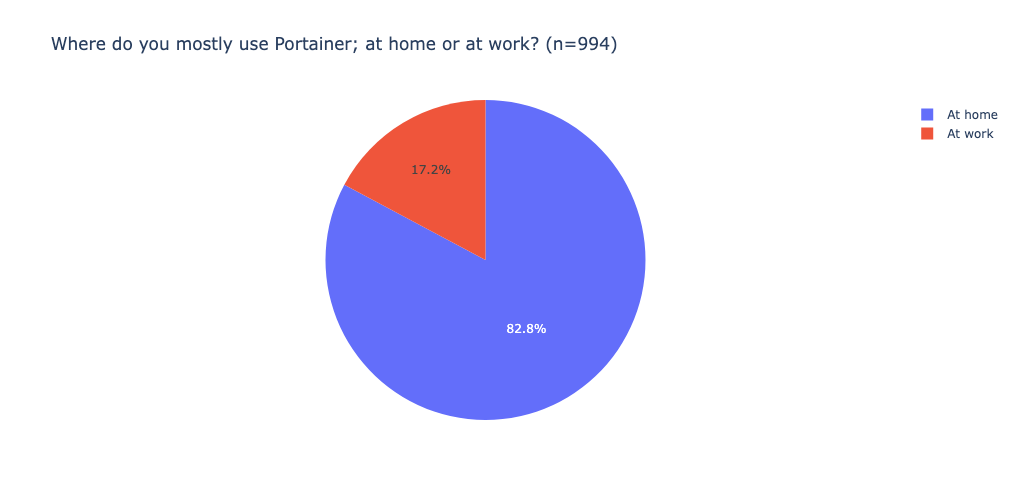

In [15]:
# Q1 - home or work ?
#

temp_series = raw_df['Q1'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series)))


# Create the pie chart
fig = px.pie(names=labels, values=sizes, title=f"{questions['Q1']} (n={len(raw_df)})")

fig.update_layout(width=900, height=500, bargap=0.05)

# Show the plot
fig.show()



In [4]:
#
# Questions Q3 to Q11 are the same data format
#

selected_qs = ['Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11']
#selected_qs = ['Q8']
for key in selected_qs:
    if key in questions and not (key == "0"): 
        value = questions[key]
        double_bar_chart(
                 key,
                 questions[key], 
                 CWORK, work_df[key].value_counts()[lambda x: x > THRESHOLD], 
                 CHOME, home_df[key].value_counts()[lambda x: x > THRESHOLD])



In [5]:
# 
# Q12.A1 - Q12.A8
# Answers are in columns Q12.A1 - Q12.A8 
# conactenate the list of value counts and pass them to the standard chart function
#

wq = pd.concat([work_df["Q12.A1"].value_counts(),\
                work_df["Q12.A3"].value_counts(),\
                work_df["Q12.A4"].value_counts(),\
                work_df["Q12.A5"].value_counts(),\
                work_df["Q12.A6"].value_counts(),\
                work_df["Q12.A7"].value_counts(),\
                work_df["Q12.A8"].value_counts()])

hq = pd.concat([home_df["Q12.A1"].value_counts(),\
                home_df["Q12.A2"].value_counts(),\
                home_df["Q12.A3"].value_counts(),\
                home_df["Q12.A4"].value_counts(),\
                home_df["Q12.A5"].value_counts(),\
                home_df["Q12.A6"].value_counts(),\
                home_df["Q12.A7"].value_counts(),\
                home_df["Q12.A8"].value_counts()])

double_bar_chart(
    "Q12.A1",
    questions["#Q12"], 
    CWORK, wq[lambda x: x > THRESHOLD], 
    CHOME, hq[lambda x: x > THRESHOLD])


In [6]:
# 
# Q13.A1 - Q13.A7
#

wq = pd.concat([work_df["Q13.A1"].value_counts(),\
                work_df["Q13.A3"].value_counts(),\
                work_df["Q13.A4"].value_counts(),\
                work_df["Q13.A5"].value_counts(),\
                work_df["Q13.A6"].value_counts(),\
                work_df["Q13.A7"].value_counts(),\
                work_df["Q13.Other"].value_counts()])

hq = pd.concat([home_df["Q13.A1"].value_counts(),\
                home_df["Q13.A2"].value_counts(),\
                home_df["Q13.A3"].value_counts(),\
                home_df["Q13.A4"].value_counts(),\
                home_df["Q13.A5"].value_counts(),\
                home_df["Q13.A6"].value_counts(),\
                home_df["Q13.A7"].value_counts(),\
                home_df["Q13.Other"].value_counts()])

double_bar_chart(
    "Q13.A1",
    questions["#Q13"], 
    CWORK, wq[lambda x: x > THRESHOLD], 
    CHOME, hq[lambda x: x > THRESHOLD])


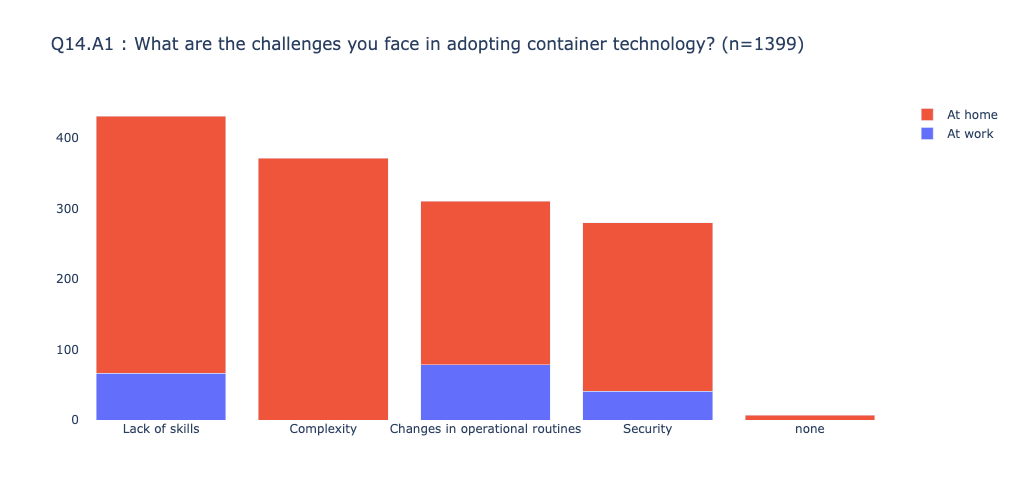

In [7]:
# 
# Q14.A1 - Q14.A4
#

wq = pd.concat([work_df["Q14.A1"].value_counts(),\
                work_df["Q14.A3"].value_counts(),\
                work_df["Q14.A4"].value_counts(),\
                work_df["Q14.Other"].value_counts()])

hq = pd.concat([home_df["Q14.A1"].value_counts(),\
                home_df["Q14.A2"].value_counts(),\
                home_df["Q14.A3"].value_counts(),\
                home_df["Q14.A4"].value_counts(),\
                home_df["Q14.Other"].value_counts()])

double_bar_chart(
    "Q14.A1",
    questions["#Q14"], 
    CWORK, wq[lambda x: x > THRESHOLD], 
    CHOME, hq[lambda x: x > THRESHOLD])


In [8]:
# 
# Q15.A1 - Q15.A4
#

# Double stack bar-chart
# Category - now, in 2 years with Home, Work stacked

NOW = "Now"
FUTURE = "In 2 Years"
NOW_FUTURE = "Now,In 2 Years"
FUTURE_NOW = "In 2 Years,Now"

categories = [ "Q15.A1", "Q15.A2", "Q15.A3", "Q15.A4", "Q15.A5"]

table_data = { 
    'Category' : ['','','','',''],
    NOW : [0,0,0,0,0],
    FUTURE : [0,0,0,0,0]
}
cat_counter = 0
for c in categories:
    print ( "looking for " + c)
    table_data['Category'][cat_counter] ( questions[c] )
    cat_counter+=1
    for t in [ NOW, FUTURE, NOW_FUTURE, FUTURE_NOW ]:
         if t in [NOW_FUTURE, FUTURE_NOW ]:
             table_data[NOW] = home_df[c].value_counts().get(t, 0) 
             table_data[FUTURE] = home_df[c].value_counts().get(t, 0) 
         elif t in [ NOW ]:
             table_data[NOW] = home_df[c].value_counts().get(t, 0) 
         else:
             table_data[FUTURE] = ( home_df[c].value_counts().get(t, 0) )

print  ( table_data )
table = pd.DataFrame(table_data)

# displaying the DataFrame
display(table)




chart_data = {
    'Category': [],   # technologies
    'Time': [],       # now, future
    'Count': [] }     # counts

for c in categories:
    for t in [ NOW, FUTURE ]:
        print ( "looking for " + c)
        chart_data['Category'].append ( questions[c] )
        chart_data['Time'].append ( t )
        chart_data['Count'].append ( \
            home_df[c].value_counts().get(t, 0) )


# Create the bar chart

wrapped_title = "Q15. " + "<br>".join(textwrap.wrap(questions["#Q15"] + ' Now vs Future Counts (Home Users)', width=100))

fig = px.bar(chart_data, x='Category', y='Count', color='Time', barmode='group',
             title=wrapped_title)

fig.update_layout(
    bargap=0.2, 
    barmode='group', 
    width=600, 
    height=500 )

fig.show()



looking for Q15.A1


TypeError: 'str' object is not callable